# Lagrangian Double Pendulum
A double pendulum is made of two simple pendulums attached end to end. We can find motion equations for a double pendulum system using either Lagrangian or Hamiltonian formulas.


In [1]:
%matplotlib inline

In [2]:
import numpy as np
from scipy.integrate import solve_ivp

import matplotlib.pyplot as plt
from IPython.display import Image

In [3]:
# The dpi (dots-per-inch) setting will affect the resolution and how large
#  the plots appear on screen and printed.  So you may want/need to adjust 
#  the figsize when creating the figure.
plt.rcParams['figure.dpi'] = 100.    # this is the default for notebook

# Change the common font size (smaller when higher dpi)
font_size = 12
plt.rcParams.update({'font.size': font_size})

In [4]:
Image(url="https://upload.wikimedia.org/wikipedia/commons/7/78/Double-Pendulum.svg")

## Lagrangian equations
I'll be using the Lagrangian equations using the angles and coordinates shown in the image above. The motion equations here are the components position and velocity of the 2 ends of each pendulum.




\begin{align*}
x_1 & = L_1\sin\theta_1 & \dot{x}_1 &= L_1\dot{\theta}_1\cos\theta_1\\
y_1 & = L_1\cos\theta_1 & \dot{y}_1 &= -L_1\dot{\theta}_1\sin\theta_1\\
x_2 & = L_1\sin\theta_1 + L_2\sin\theta_2 & \dot{x}_2 &= L_1\dot{\theta}_1\cos\theta_1 + L_2\dot{\theta}_2\cos\theta_2\\
y_2 & = L_1\cos\theta_1 + L_2\cos\theta_2 & \dot{y}_2 &= -L_1\dot{\theta}_1\sin\theta_1 - L_2\dot{\theta}_2\sin\theta_2
\end{align*}


The kinetic and potential energy equations are then:

\begin{align}
T &= \tfrac{1}{2}m_1v_1^2 + \tfrac{1}{2}m_2v_2^2 = \tfrac{1}{2}m_1(\dot{x}_1^2 + \dot{y}_1^2) + \tfrac{1}{2}m_2(\dot{x}_2^2 + \dot{y}_2^2)\\
&= \tfrac{1}{2}m_1L_1^2\dot{\theta}_1^2 + \tfrac{1}{2}m_2[L_1^2\dot{\theta}_1^2 + L_2^2\dot{\theta}_2^2 + 2L_1L_2\dot{\theta}_1\dot{\theta}_2\cos(\theta_1 - \theta_2)]\\
U &= m_1gy_1 + m_2gy_2 = -(m_1 + m_2)L_1g\cos\theta_1 - m_2L_2g\cos\theta_2
\end{align}



So the total Lagranian equation is then: $\mathcal{L} = {T} - {U}$

\begin{align}
\mathcal{L} =  \tfrac{1}{2}(m_1+m_2)L_1^2\dot{\theta}_1^2 + \tfrac{1}{2}m_2L_2^2\dot{\theta}_2^2 + m_2L_1L_2\dot{\theta}_1\dot{\theta}_2\cos(\theta_1 - \theta_2) + (m_1+m_2)L_1g\cos\theta_1 + m_2gL_2\cos\theta_2.
\end{align}

The Euler-Lagrange equations are:
\begin{align*}
\frac{\mathrm{d}}{\mathrm{d}t}\left(\frac{\partial\mathcal{L}}{\partial \dot{q}_i}\right) - \frac{\partial \mathcal{L}}{\partial q_i} = 0 \quad \mathrm{for}\;q_i = \theta_1, \theta_2.
\end{align*}

Which, given the coordinates and conventions of our double pendulum, gives us:
\begin{align*}
(m_1 + m_2)L_1 \ddot{\theta}_1 + m_2L_2\ddot{\theta}_2\cos(\theta_1 - \theta_2) + m_2L_2\dot{\theta}_2^2\sin(\theta_1 - \theta_2) + (m_1+m_2)g\sin\theta_1 &= 0,\\
m_2L_2\ddot{\theta}_2 + m_2L_1\ddot{\theta}_1\cos(\theta_1 - \theta_2) - m_2L_1\dot{\theta}_1^2\sin(\theta_1 - \theta_2) + m_2g\sin\theta_2 = 0.
\end{align*}

\begin{align*}
\dot{z}_1 = \frac{m_2g\sin\theta_2\cos(\theta_1-\theta_2) - m_2\sin(\theta_1 - \theta_2)(L_1z_1^2\cos(\theta_1 - \theta_2) + L_2z_2^2) - (m_1+m_2)g\sin\theta_1}{L_1(m_1 + m_2\sin^2(\theta_1-\theta_2))},\\
\dot{z}_2 = \frac{(m_1+m_2)(L_1z_1^2\sin(\theta_1-\theta_2) - g\sin\theta_2 + g\sin\theta_1\cos(\theta_1-\theta_2))/+m_2L_2z_2^2\sin(\theta_1-\theta_2)\cos(\theta_1-\theta_2)}{L_2(m_1 + m_2\sin^2(\theta_1-\theta_2))}
\end{align*}

I read through https://scipython.com/blog/the-double-pendulum/ for help with the markdowns here.

## Pendulum class and utility functions

In [5]:
class DoublePendulum():
    """
    DoublePendulum class implements the parameters and Lagrange's equations for 
     a double pendulum.
     
    Parameters
    ----------
    L1 : float
        length of the first pendulum
    L2 : float
        length of the second pendulum
    g : float
        gravitational acceleration at the earth's surface 
    mn : float
        mass of pendulum "bobs" *hehehe* where n is how many bobs there are

    Methods
    -------
    dy_dt(t, y)
        Returns the right side of the differential equation in vector y, 
        given time t and the corresponding value of y.
    """
    def __init__(self, L1=1.,L2=1, m1=1., m2=1, g=1.
                ):
        self.L1 = L1
        self.L2 = L2
        self.g = g
        self.m1 = m1
        self.m2 = m2
    
    def dy_dt(self, t, y):
        """
        This function returns the right-hand side of the diffeq: 
        [dphi/dt d^2phi/dt^2]
        
        Parameters
        ----------
        t : float
            time 
        y : float
            A 4-component vector with 
            y[0] = theta1 and y[1] = theta1_dot
            y[2] = theta2 and y[3] = theta12_dot
            
        Returns
        -------
        
        """
        theta1, z1, theta2, z2 = y
        
        c, s = np.cos(theta1 - theta2), np.sin(theta1 - theta2)

        theta1_dot = z1
        z1_dot = (self.m2*self.g*np.sin(theta2)*c - self.m2*s*(self.L1*z1**2*c + self.L2*z2**2) -
                 (self.m1 + self.m2)*self.g*np.sin(theta1)) / self.L1 / (self.m1 + self.m2*s**2)
        theta2_dot = z2
        z2_dot = ((self.m1 + self.m2)*(self.L1*z1**2*s - self.g*np.sin(theta2) + self.g*np.sin(theta1)*c) + 
                 self.m2*self.L2*z2**2*s*c) / self.L2 / (self.m1 + self.m2*s**2)
        return theta1_dot, z1_dot, theta2_dot, z2_dot
        
        
    
    def solve_ode(self, t_pts, theta1_0, theta1_dot_0, theta2_0, theta2_dot_0,
                  abserr=1.0e-10, relerr=1.0e-10):
        """
        Solve the ODE given initial conditions.
        Specify smaller abserr and relerr to get more precision.
        """
        y = [theta1_0, theta1_dot_0, theta2_0, theta2_dot_0] 
        solution = solve_ivp(self.dy_dt, (t_pts[0], t_pts[-1]), 
                             y, t_eval=t_pts, 
                             atol=abserr, rtol=relerr)
        theta1_0, theta1_dot_0, theta2_0, theta2_dot_0 = solution.y

        return theta1_0, theta1_dot_0, theta2_0, theta2_dot_0
    
    def calc_E(y):
        """Return the total energy of the system."""

        th1, th1d, th2, th2d = y.T
        U = -(m1+m2)*L1*g*np.cos(th1) - m2*L2*g*np.cos(th2)
        T = 0.5*m1*(L1*th1d)**2 + 0.5*m2*((L1*th1d)**2 + (L2*th2d)**2 +
                2*L1*L2*th1d*th2d*np.cos(th1-th2))
        return T + U

In [6]:
def plot_y_vs_x(x, y, axis_labels=None, label=None, title=None, 
                color=None, linestyle=None, semilogy=False, loglog=False,
                ax=None):
    """
    Generic plotting function: return a figure axis with a plot of y vs. x,
    with line color and style, title, axis labels, and line label
    """
    if ax is None:        # if the axis object doesn't exist, make one
        ax = plt.gca()

    if (semilogy):
        line, = ax.semilogy(x, y, label=label, 
                            color=color, linestyle=linestyle)
    elif (loglog):
        line, = ax.loglog(x, y, label=label, 
                          color=color, linestyle=linestyle)
    else:
        line, = ax.plot(x, y, label=label, 
                    color=color, linestyle=linestyle)

    if label is not None:    # if a label if passed, show the legend
        ax.legend()
    if title is not None:    # set a title if one if passed
        ax.set_title(title)
    if axis_labels is not None:  # set x-axis and y-axis labels if passed  
        ax.set_xlabel(axis_labels[0])
        ax.set_ylabel(axis_labels[1])

    return ax, line

In [7]:
def start_stop_indices(t_pts, plot_start, plot_stop):
    start_index = (np.fabs(t_pts-plot_start)).argmin()  # index in t_pts array 
    stop_index = (np.fabs(t_pts-plot_stop)).argmin()  # index in t_pts array 
    return start_index, stop_index

## Make double pendulum plots 

In [8]:
# Labels for individual plot axes
theta_vs_time_labels = (r'$t$', r'$\theta(t)$')

# Common plotting time (generate the full time then use slices)
t_start = 0.
t_end = 50.
delta_t = 0.01

t_pts = np.arange(t_start, t_end+delta_t, delta_t)  

L1 = 1.
L2 = 1.
g = 1.
m1 = 1.
m2 = 1.

# Instantiate a pendulum 
dp1 = DoublePendulum(L1=L1, L2=L2, g=g, m1=m1, m2=m2)


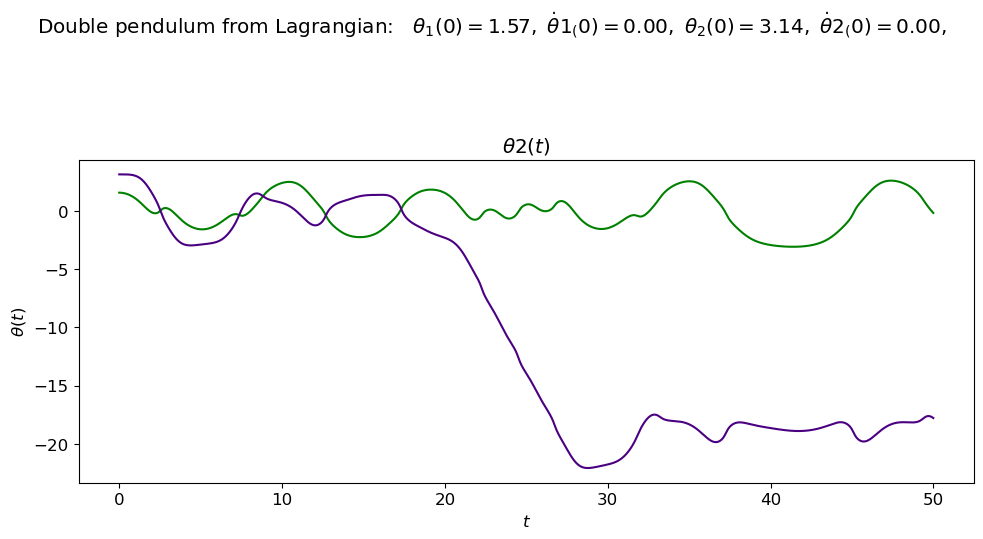

In [9]:
# both plots: same initial conditions
theta1_0 = np.pi/2
theta1_dot_0 = 0.
theta2_0 = np.pi
theta2_dot_0 = 0.
theta1, theta1_dot, theta2, theta2_dot = \
                      dp1.solve_ode(t_pts, theta1_0, theta1_dot_0, theta2_0, theta2_dot_0)


# start the plot!
fig = plt.figure(figsize=(10,5))
overall_title = 'Double pendulum from Lagrangian:  ' + \
                rf' $\theta_1(0) = {theta1_0:.2f},$' + \
                rf' $\dot\theta1_(0) = {theta1_dot_0:.2f},$' + \
                rf' $\theta_2(0) = {theta2_0:.2f},$' + \
                rf' $\dot\theta2_(0) = {theta2_dot_0:.2f},$' + \
                '\n'     # \n means a new line (adds some space here)
fig.suptitle(overall_title, va='baseline')
    
# first plot: phi plot 
ax_a = fig.add_subplot(1,1,1)                  

start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(t_pts[start : stop], theta1[start : stop], 
            axis_labels=theta_vs_time_labels, 
            color='green',
            label=None, 
            title=r'$\theta1(t)$', 
            ax=ax_a)  
plot_y_vs_x(t_pts[start : stop], theta2[start : stop],
            axis_labels=theta_vs_time_labels, 
            color='indigo',
            label=None, 
            title=r'$\theta2(t)$', 
            ax=ax_a)
                              
fig.tight_layout()
fig.savefig('doublependulum_Lagrange1.png', bbox_inches='tight')  

### For the 1st 10 seconds or so, the pendulums both move largely in sync, but then are out of phase from about 11-22 seconds, and then after that their motions are very different.

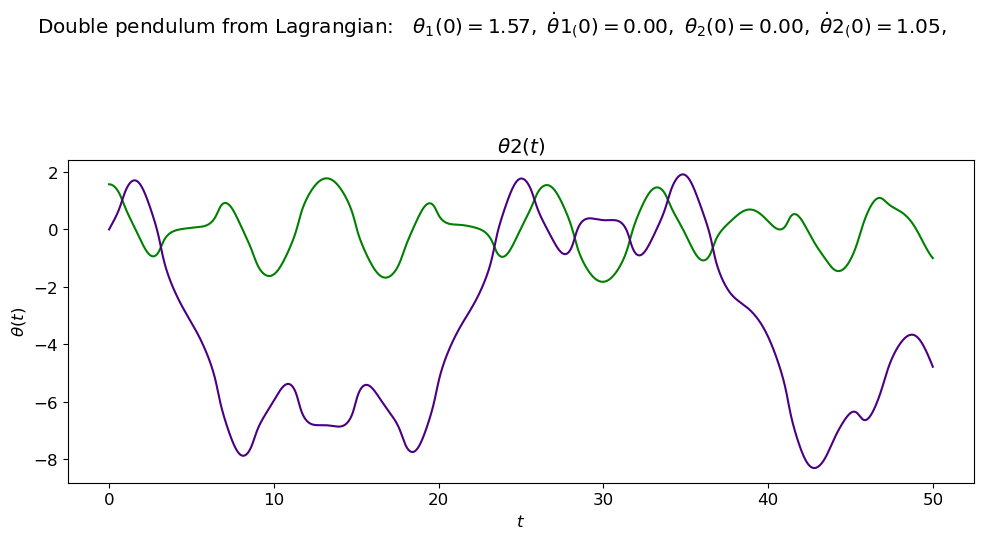

In [10]:
# both plots: same initial conditions
theta1_0 = np.pi/2
theta1_dot_0 = 0.
theta2_0 = 0.
theta2_dot_0 = np.pi/3
theta1, theta1_dot, theta2, theta2_dot = \
                      dp1.solve_ode(t_pts, theta1_0, theta1_dot_0, theta2_0, theta2_dot_0)


# start the plot!
fig = plt.figure(figsize=(10,5))
overall_title = 'Double pendulum from Lagrangian:  ' + \
                rf' $\theta_1(0) = {theta1_0:.2f},$' + \
                rf' $\dot\theta1_(0) = {theta1_dot_0:.2f},$' + \
                rf' $\theta_2(0) = {theta2_0:.2f},$' + \
                rf' $\dot\theta2_(0) = {theta2_dot_0:.2f},$' + \
                '\n'     # \n means a new line (adds some space here)
fig.suptitle(overall_title, va='baseline')
    
# first plot: phi plot 
ax_a = fig.add_subplot(1,1,1)                  

start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(t_pts[start : stop], theta1[start : stop], 
            axis_labels=theta_vs_time_labels, 
            color='green',
            label=None, 
            title=r'$\theta1(t)$', 
            ax=ax_a)  
plot_y_vs_x(t_pts[start : stop], theta2[start : stop],
            axis_labels=theta_vs_time_labels, 
            color='indigo',
            label=None, 
            title=r'$\theta2(t)$', 
            ax=ax_a)
                              
fig.tight_layout()
fig.savefig('doublependulum_Lagrange2.png', bbox_inches='tight')  

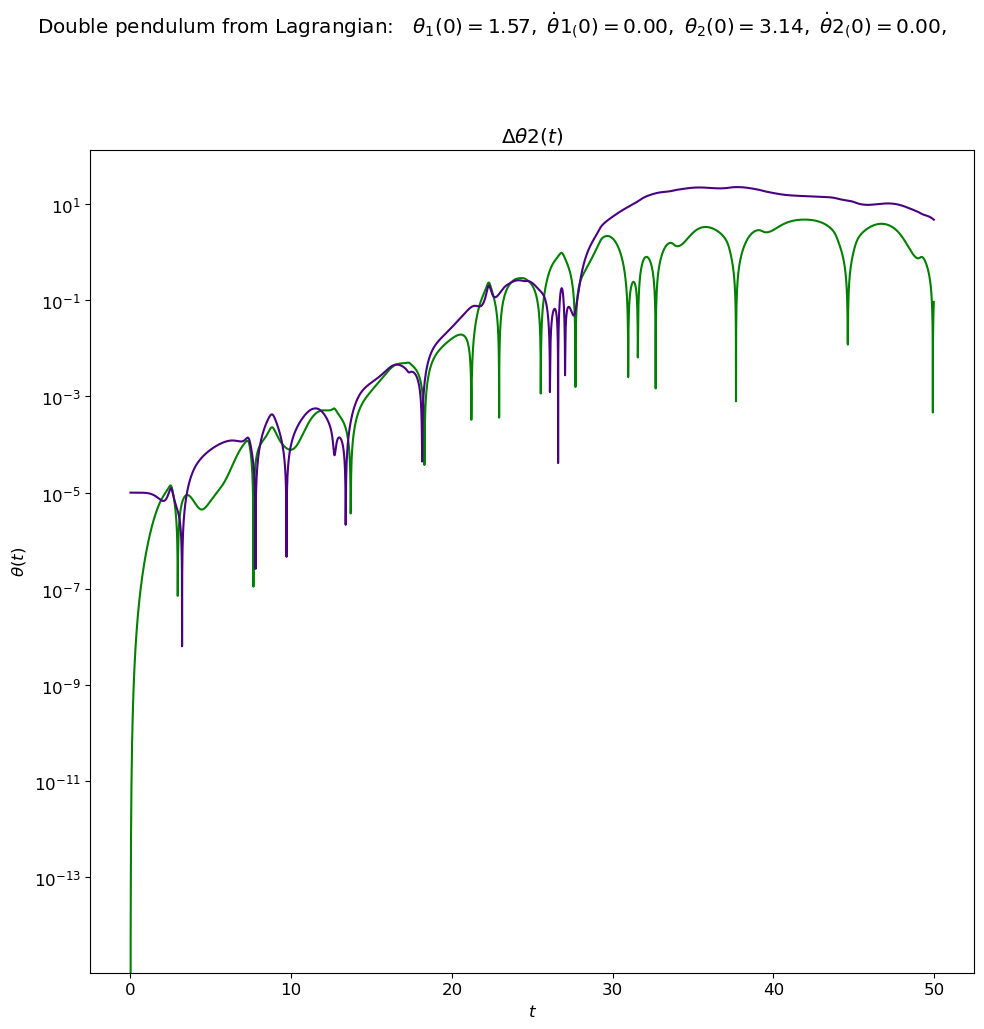

In [11]:
# both plots: same initial conditions
theta1_0 = np.pi/2
theta1_dot_0 = 0.
theta2_0 = np.pi
theta2_dot_0 = 0.
theta1, theta1_dot, theta2, theta2_dot = \
                      dp1.solve_ode(t_pts, theta1_0, theta1_dot_0, theta2_0, theta2_dot_0)
theta1b, theta1b_dot, theta2b, theta2b_dot = \
                      dp1.solve_ode(t_pts, theta1_0, theta1_dot_0, theta2_0-0.00001, theta2_dot_0)

# start the plot!
fig = plt.figure(figsize=(10,10))
overall_title = 'Double pendulum from Lagrangian:  ' + \
                rf' $\theta_1(0) = {theta1_0:.2f},$' + \
                rf' $\dot\theta1_(0) = {theta1_dot_0:.2f},$' + \
                rf' $\theta_2(0) = {theta2_0:.2f},$' + \
                rf' $\dot\theta2_(0) = {theta2_dot_0:.2f},$' + \
                '\n'     # \n means a new line (adds some space here)
fig.suptitle(overall_title, va='baseline')
    
# first plot: phi plot 
ax_a = fig.add_subplot(1,1,1)                  

start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(t_pts[start : stop], np.abs(theta1[start : stop]-theta1b[start : stop]), 
            axis_labels=theta_vs_time_labels, 
            color='green', semilogy=True,
            label=None, 
            title=r'$\Delta\theta1(t)$', 
            ax=ax_a)  
plot_y_vs_x(t_pts[start : stop], np.abs(theta2[start : stop]-theta2b[start : stop]), 
            axis_labels=theta_vs_time_labels, 
            color='indigo', semilogy=True,
            label=None, 
            title=r'$\Delta\theta2(t)$', 
            ax=ax_a)
                              
fig.tight_layout()
fig.savefig('doublependulum_Lagrange3.png', bbox_inches='tight')  

### This graph shows that the pendulums start off without differing much, but over time the differences increase exponentially and the motion of the system is chaotic.

# Animation

In [13]:
# Common plotting time (generate the full time then use slices)
t_start = 0.
t_end = 400.
delta_t = 0.05


t_pts = np.arange(t_start, t_end+delta_t, delta_t)  

theta1_0 = np.pi/2
theta1_dot_0 = 0.
theta2_0 = np.pi
theta2_dot_0 = 0.
theta1, theta1_dot, theta2, theta2_dot = \
                      dp1.solve_ode(t_pts, theta1_0, theta1_dot_0, theta2_0, theta2_dot_0)
theta1b, theta1_dot, theta2b, theta2_dot = \
                      dp1.solve_ode(t_pts, theta1_0, theta1_dot_0, theta2_0+0.0001, theta2_dot_0)

from scipy.integrate import odeint

import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

def xy_coords(x0, y0, theta, L):
    """
    Converts the angle theta and length of the pendulum L to the position of the bob in cartesian coordinates x,y
    
    """
    x = x0 + L * np.sin(theta)
    y = y0 - L * np.cos(theta)
    return x, y

In [14]:
%%capture
x_min = -3.2
x_max = -x_min
y_min = -3.2
y_max = -y_min

fig_anim = plt.figure(figsize=(5,5), num='Double Pendulum')
ax_anim = fig_anim.add_subplot(1,1,1)
ax_anim.set_xlim(x_min, x_max)
ax_anim.set_ylim(y_min, y_max)

x0,y0 = 0., 0.
pt0_anim, = ax_anim.plot(x0, y0,
                        'o', markersize=6,
                        color='green')
x1, y1 = xy_coords(x0, y0, theta1[0], dp1.L1)
pt1_anim, = ax_anim.plot(x1, y1,
                        'o', markersize=12,
                        color='indigo')
ln1_anim, = ax_anim.plot([x0, x1], [y0, y1], color='indigo', lw=3)
x2, y2 = xy_coords(x1, y1, theta2[0], dp1.L2)
pt2_anim, = ax_anim.plot(x2, y2,
                        'o', markersize=12,
                        color='indigo')
ln2_anim, = ax_anim.plot([x1, x2], [y1, y2], color='indigo', lw=3)

x1b, y1b = xy_coords(x0, y0, theta1b[0], dp1.L1)
pt1b_anim, = ax_anim.plot(x1b, y1b,
                        'o', markersize=12,
                        color='forestgreen')

ln1b_anim, = ax_anim.plot([x0, x1b], [y0, y1b], color='forestgreen', lw=3)

x2b, y2b = xy_coords(x1b, y1b, theta2b[0], dp1.L2)
pt2b_anim, = ax_anim.plot(x2b, y2b,
                        'o', markersize=12,
                        color='forestgreen')
ln2b_anim, = ax_anim.plot([x1b, x2b], [y1b, y2b], color='forestgreen', lw=3)

ax_anim.set_aspect(1)
ax_anim.axis('off')
fig_anim.tight_layout

In [15]:
def AnimationDoublePendulumPlot(i):
    """
   
    """
    i_skip = 2 * i

    x0,y0 = 0., 0.
    pt0_anim.set_data(x0,y0)
    
    x1, y1 = xy_coords(x0, y0, theta1[i_skip], dp1.L1)
    pt1_anim.set_data(x1,y1) 
    ln1_anim.set_data([x0,x1],[y0,y1])
    
    x2, y2 = xy_coords(x1, y1, theta2[i_skip], dp1.L2)
    pt2_anim.set_data(x2,y2)
    ln2_anim.set_data([x1,x2],[y1,y2])

    x1b, y1b = xy_coords(x0, y0, theta1b[i_skip], dp1.L1)
    pt1b_anim.set_data(x1b,y1b)

    ln1b_anim.set_data([x0,x1b],[y0,y1b])

    x2b, y2b = xy_coords(x1b, y1b, theta2b[i_skip], dp1.L2)
    pt2b_anim.set_data(x2b,y2b)
    ln2b_anim.set_data([x1b,x2b],[y1b,y2b])
    
    return (pt0_anim, pt1_anim, ln1_anim, pt2_anim, ln2_anim, pt1b_anim, ln1b_anim, pt2b_anim, ln2b_anim)

In [16]:
frame_interval = 20
frame_number = 1000
anim = animation.FuncAnimation(fig_anim, AnimationDoublePendulumPlot, init_func= None, 
                               frames = frame_number, interval = frame_interval, blit=True, repeat=False)

HTML(anim.to_jshtml())